# Prepare SST dataset for comparison with CESM-LE

[Optimum Interpolation Sea Surface Temperature (OISST) v2.1](https://www.ncdc.noaa.gov/oisst/optimum-interpolation-sea-surface-temperature-oisst-v21)

The NOAA 1/4° daily Optimum Interpolation Sea Surface Temperature (or daily OISST) is an analysis constructed by combining observations from different platforms (satellites, ships, buoys and Argo floats) on a regular global grid. A spatially complete SST map is produced by interpolating to fill in gaps. The methodology includes bias adjustment of satellite and ship observations (referenced to buoys) to compensate for platform differences and sensor biases. This proved critical during the Mt. Pinatubo eruption in 1991, when the widespread presence of volcanic aerosols resulted in infrared satellite temperatures that were much cooler than actual ocean temperatures (Reynolds 1993). Starting from April 1, 2020, NCEI released a new version, OISST v2.1, to replace OISST v2. OISST v2 had been stopped on April 26, 2020 due to unavailable input data to it.

Currently OISST v2.1 data are available from Sept 1, 1981 onward and updated nominally daily. The new version has significant quality improvement for data starting from January 1, 2016 onward - see below for more details. For the data from September 1981 to December 2015, data for SST and SST anomaly are the same as v2 but format was updated from netCDF3 to netCDF4 with updated metadata in v2.1. 


This notebook does the following operations:

1. Download daily data via HTTP protocol from [here](https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr).

1. Compute monthly means from daily data.

1. Regrid monthly data from 1/4° native grid to the POP `gx1v6` grid. This has a few steps:
    - Generate SCRIP grid files for source and destination grids;
    - Use ESMF tool box to generate remapping weights;
    - Apply remapping weights.
    
1. Assemble remapped monthly data into a single file subsetted for the Southern Ocean domain.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import subprocess
import urllib
import calendar
from datetime import datetime
import tqdm

import scipy.sparse as sps
import numpy as np

import dask
import xarray as xr

import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [3]:
clobber = False
year_start = 1991
year_end = 2019
dst_grid = 'POP_gx1v6'

FILE_OUT = f'{util.project_tmpdir}/oisst-avhrr-v02r01.{year_start}-{year_end}_DJF.{dst_grid}.zarr'
FILE_OUT    

'/glade/p/cgd/oce/projects/krill-cesm-le/data/oisst-avhrr-v02r01.1991-2019_DJF.POP_gx1v6.zarr'

## Setup regridding machinery

Make SCRIP grid file for source grid.

In [4]:
gridfile_directory = f'{util.project_tmpdir}/regrid'
os.makedirs(gridfile_directory, exist_ok=True)

In [5]:
src_grid = 'latlon_0_25x0_25_lon0'
src_grid_file = f'{gridfile_directory}/{src_grid}.nc'

if not os.path.exists(src_grid_file) or clobber:
    dso = util.latlon_to_scrip(
        nx=1440, 
        ny=720, 
        lon0=0., 
        file_out=src_grid_file,
    )

Make SCRIP grid file for ocean model grid.

In [6]:
dst_grid_file= f'{gridfile_directory}/{dst_grid}.nc'

if not os.path.exists(dst_grid_file) or clobber:
    dso = pop_tools.get_grid('POP_gx1v6', scrip=True)
    del dso.attrs['region_mask_regions']
    print(f'writing {dst_grid_file}')
    dso.to_netcdf(dst_grid_file)

Call `ESMF_RegridWeightGen` to generate weight file.

In [7]:
%%time
method = 'conserve'
weight_file = f'{gridfile_directory}/{src_grid}_to_{dst_grid}_{method}.nc'

if not os.path.exists(weight_file) or clobber:
    cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
    out = subprocess.run(cmd, capture_output=True, check=True)
    print(out.stdout.decode('UTF-8'))

CPU times: user 155 µs, sys: 0 ns, total: 155 µs
Wall time: 85.4 µs


Set up remapping operator

In [8]:
with xr.open_dataset(src_grid_file) as src:
    dims_src = tuple(src.grid_dims.values[::-1])
    
with xr.open_dataset(dst_grid_file) as dst:
    dims_dst = tuple(dst.grid_dims.values[::-1])
    mask_dst = dst.grid_imask.values.reshape(dims_dst).T
    
n_dst = np.prod(dims_dst)
n_src = np.prod(dims_src)
print(f'source grid dims: {dims_src}')
print(f'destination grid dims: {dims_dst}')

source grid dims: (720, 1440)
destination grid dims: (384, 320)


In [9]:
%%time
with xr.open_dataset(weight_file) as mf:
    row = mf.row.values - 1
    col = mf.col.values - 1
    S = mf.S.values
    weights = sps.coo_matrix((S, (row, col)), shape=[n_dst, n_src])
weights

CPU times: user 14 ms, sys: 15.1 ms, total: 29.1 ms
Wall time: 176 ms


<122880x1036800 sparse matrix of type '<class 'numpy.float64'>'
	with 1373460 stored elements in COOrdinate format>

### Functions to do remapping by applying weights

Borrowed from [xESMF](https://github.com/JiaweiZhuang/xESMF/blob/master/xesmf/smm.py).

In [10]:
def apply_weights(weights, indata, shape_in, shape_out):
    '''
    Apply regridding weights to data.
    Parameters
    ----------
    A : scipy sparse COO matrix
    indata : numpy array of shape ``(..., n_lat, n_lon)`` or ``(..., n_y, n_x)``.
        Should be C-ordered. Will be then tranposed to F-ordered.
    shape_in, shape_out : tuple of two integers
        Input/output data shape for unflatten operation.
        For rectilinear grid, it is just ``(n_lat, n_lon)``.
    Returns
    -------
    outdata : numpy array of shape ``(..., shape_out[0], shape_out[1])``.
        Extra dimensions are the same as `indata`.
        If input data is C-ordered, output will also be C-ordered.
    '''

    # COO matrix is fast with F-ordered array but slow with C-array, so we
    # take in a C-ordered and then transpose)
    # (CSR or CRS matrix is fast with C-ordered array but slow with F-array)
    if not indata.flags['C_CONTIGUOUS']:
        warnings.warn("Input array is not C_CONTIGUOUS. "
                      "Will affect performance.")

    # get input shape information
    shape_horiz = indata.shape[-2:]
    extra_shape = indata.shape[0:-2]

    assert shape_horiz == shape_in, (
        'The horizontal shape of input data is {}, different from that of'
        'the regridder {}!'.format(shape_horiz, shape_in)
        )

    assert shape_in[0] * shape_in[1] == weights.shape[1], (
        "ny_in * nx_in should equal to weights.shape[1]")

    assert shape_out[0] * shape_out[1] == weights.shape[0], (
        "ny_out * nx_out should equal to weights.shape[0]")

    # use flattened array for dot operation
    indata_flat = indata.reshape(-1, shape_in[0]*shape_in[1])
    outdata_flat = weights.dot(indata_flat.T).T

    # unflattened output array
    outdata = outdata_flat.reshape(
        [*extra_shape, shape_out[0], shape_out[1]])
    return outdata

Define regridding function 

In [11]:
def regrid_dataarray(da_in, renormalize=True, apply_mask=True):
    # Pull data, dims and coords from incoming DataArray
    data_src = da_in.data
    non_lateral_dims = da_in.dims[:-2]
    copy_coords = {d: da_in.coords[d] for d in non_lateral_dims if d in da_in.coords}

    # If renormalize == True, remap a field of ones
    if renormalize:
        ones_src = np.where(np.isnan(data_src), 0.0, 1.0)
        data_src = np.where(np.isnan(data_src), 0.0, data_src)

    # remap the field
    data_dst = apply_weights(
        weights, data_src, dims_src, dims_dst
    )

    # Renormalize to include non-missing data_src
    if renormalize:
        old_err_settings = np.seterr(invalid='ignore')
        ones_dst = apply_weights(
            weights, ones_src, dims_src, dims_dst
        )
        ones_dst = np.where(ones_dst > 0.0, ones_dst, np.nan)
        data_dst = data_dst / ones_dst
        data_dst = np.where(ones_dst > 0.0, data_dst, np.nan)
        np.seterr(**old_err_settings)

    # reform into xarray.DataArray
    da_out = xr.DataArray(
        data_dst, name=da_in.name, dims=da_in.dims, attrs=da_in.attrs, coords=copy_coords
    )

    # Apply a missing-values mask
    if apply_mask:
        da_out = da_out.where(mask_dst.T)

    return da_out

## Download and process files

Set up some directories and xarray option for reading files.

In [12]:
dirloc = f'{util.project_tmpdir}/roisst'
dirtmp = f'/glade/scratch/{os.environ["USER"]}/roisst_daily'
os.makedirs(dirloc, exist_ok=True)
os.makedirs(dirtmp, exist_ok=True)

Define a function for computing monthly means from daily files.

In [13]:
@dask.delayed
def daily_to_mon(daily_files, mon_file):
    """compute monthly means from daily data"""
    ds = xr.open_mfdataset(daily_files, 
                           combine='by_coords',
                           decode_times=False,
                           decode_coords=False,
                          )
    assert ds.time.units == "days since 1978-01-01 12:00:00", (
        f'unexpected units: {ds.time.units}'
    )
    computed_dset = (ds
                     .mean(dim='time', keep_attrs=True)
                     .expand_dims(time=[ds.time.mean('time').values])
                    )
    
    # amend history
    history = ''
    if 'history' in computed_dset.attrs:
        history = computed_dset.attrs['history']
    computed_dset.attrs['history'] = 'average computed over: '+','.join(
        [os.path.basename(f) for f in daily_files]
    )
    
    # determine vars to regrid
    variables = computed_dset.variables    
    variables_to_regrid = [v for v in variables 
                           if not {'lat', 'lon'} - set(computed_dset[v].dims)
                          ]
    other_vars = [v for v in variables 
              if not {'lat', 'lon', 'zlev'}.intersection(set(computed_dset[v].dims))
             ]
    
    computed_dset_dst = computed_dset[other_vars]
    
    # regrid the data
    for v in variables_to_regrid:
        computed_dset_dst[v] = regrid_dataarray(
            computed_dset[v].compute(),
            renormalize=True, 
            apply_mask=True,
        ).squeeze('zlev')
    
    computed_dset_dst = computed_dset_dst.rename(
        {'lat': 'nlat', 'lon': 'nlon'}
    ).drop('zlev')
    
    # copy back encoding and attrs
    for v in computed_dset_dst.variables:
        encoding = ds[v].encoding
        attrs = ds[v].attrs
        if '_FillValue' not in encoding:
            encoding['_FillValue'] = None
        computed_dset_dst[v].encoding = encoding
        computed_dset_dst[v].attrs = attrs

    # set the time bounds
    computed_dset_dst['time_bnds'] = xr.DataArray(
        [[ds.time.values[0]-0.5, ds.time.values[-1]+0.5]], 
        dims=('time', 'd2'),
        coords=dict(time=computed_dset_dst.time),
        attrs=dict(long_name='time coverage',)
    )
    computed_dset_dst.time_bnds.encoding['_FillValue'] = None
    computed_dset_dst.time.attrs['long_name'] = 'time'
    computed_dset_dst.time.attrs['bounds'] = 'time_bnds'
    
    # write data to file
    computed_dset_dst.to_netcdf(mon_file, unlimited_dims=['time']) 
    

In [14]:
url = 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr'

@dask.delayed
def get_daily_files(year, month, day):
    """download remote files if needed"""
    file_name = f'oisst-avhrr-v02r01.{year:04d}{month:02d}{day:02d}.nc'            
    f_local = f'{dirtmp}/{file_name}'                
    if not os.path.exists(f_local) or clobber:
        dirsub = f'{year:04d}{month:02d}'
        f_remote = f'{url}/{dirsub}/{file_name}'
        urllib.request.urlretrieve(f_remote, f_local)   

    return f_local

def eomday(year, month):
    _, lastday = calendar.monthrange(year, month)     
    return lastday

In [15]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

try:
    cluster
    client
except:
    cluster = NCARCluster()
    cluster.scale(12)
    client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.14:34617 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [16]:
# loop over years/months/days
# generate a file name and URL
# save a list of files to transfer
delayed_objs = []
sst_files = []

for year in tqdm.tqdm(range(year_start, year_end+1)):

    for month in range(1, 13):
        
        # name the monthly file, generate if necessary
        mon_file = f'{dirloc}/oisst-avhrr-v02r01.{year:04d}{month:02d}_{dst_grid}.nc'
        sst_files.append(mon_file)
        if os.path.exists(mon_file) and not clobber:
            continue

        # loop over daily files and transfer if necessary
        daily_files = dask.compute(*[
            get_daily_files(year, month, day) for day in range(1, eomday(year, month)+1)
        ])

        # compute monthly mean and write monthly file
        delayed_objs.append(daily_to_mon(daily_files, mon_file))

if delayed_objs:
    res = dask.compute(*delayed_objs)

100%|██████████| 29/29 [00:09<00:00,  2.91it/s]


In [17]:
sst_files

['/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199101_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199102_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199103_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199104_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199105_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199106_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199107_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199108_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199109_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roisst/oisst-avhrr-v02r01.199110_POP_gx1v6.nc',
 '/glade/p/cgd/oce/projects/krill-cesm-le/data/roi

In [18]:
%%time
ds = xr.open_mfdataset(sst_files, combine='by_coords', decode_times=False)
ds = ds.set_coords(ds.time.bounds)
time_bnds = ds[ds.time.bounds]
ds = xr.decode_cf(ds.drop(ds.time.bounds), decode_times=True, use_cftime=True)
ds['time_bnds'] = time_bnds.assign_coords(time=ds.time)
ds

CPU times: user 3.45 s, sys: 309 ms, total: 3.76 s
Wall time: 9.71 s


,Array,Chunk
Bytes,171.05 MB,491.52 kB
Shape,"(348, 384, 320)","(1, 384, 320)"
Count,1044 Tasks,348 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,171.05 MB,491.52 kB
Shape,"(348, 384, 320)","(1, 384, 320)"
Count,1044 Tasks,348 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [19]:
ds_djf = util.ann_mean(ds, season='DJF')
util.write_ds_out(ds_djf, FILE_OUT)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/oisst-avhrr-v02r01.1991-2019_DJF.POP_gx1v6.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	time = 28 ;

variables:
	float64 anom(time, nlat, nlon) ;
		anom:long_name = Daily sea surface temperature anomalies ;
		anom:valid_min = -1200 ;
		anom:valid_max = 1200 ;
		anom:units = Celsius ;
	float64 err(time, nlat, nlon) ;
		err:long_name = Estimated error standard deviation of analysed_sst ;
		err:units = Celsius ;
		err:valid_min = 0 ;
		err:valid_max = 1000 ;
	float64 ice(time, nlat, nlon) ;
		ice:long_name = Sea ice concentration ;
		ice:units = % ;
		ice:valid_min = 0 ;
		ice:valid_max = 100 ;
	float64 sst(time, nlat, nlon) ;
		sst:long_name = Daily sea surface temperature ;
		sst:units = Celsius ;
		sst:valid_min = -300 ;
		sst:valid_max = 4500 ;
	int64 time(time) ;

// global attributes:
}


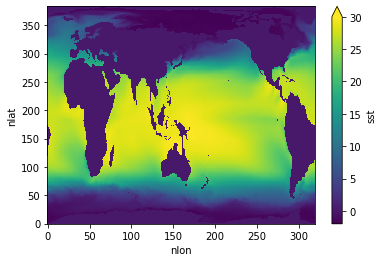

In [20]:
ds_djf.sst.mean('time').plot(vmin=-2, vmax=30)

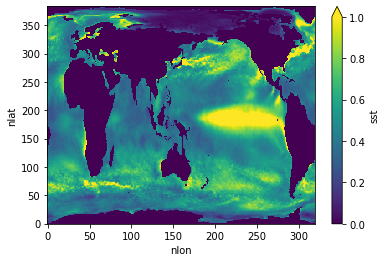

In [21]:
ds_djf.sst.std('time').plot(vmin=0, vmax=1)